DSC 232R - Franky Liu
# Recommendation Model based on Steam Reviews 

The project will explore the Kaggle dataset 100 Million+ Steam Reviews, which contains data such as steamid, language, review sentiment, helpfulness score, review body, among many others. 
The goal of this project is to combine two different machine learning models into an intelligence pipeline to create a recommendation system based on review sentiment and predicted playtime, 
which will all be implemented in Apache Spark. First, we will first apply NLP techniques such as tokenization, stopword removal, and IDF feature processing to clean and prepare our data. Using
these processed features, we will build a logistic regression model that classifies user sentiment (positive or negative) and if they would recommend the game (0 or 1). Following that,
we will build a linear regression model that predicts playtime based on inputs such as the full review text, past playtime, as well as the predicted sentiment from the logistic regression model. 
Lastly, we will integrate the outputs from the previous two models into a single intelligence pipeline to create a recommendation system. This system recommends games by predicting how much time
a user might spend on different titles and selecting the title with the highest projected playtime. This recommendation system aims to simulate a real-world machine learning pipeline that could
be the framework of much more powerful recommendation systems that platforms like Steam might use. 

## Part 1 - Installing dependencies and downloading the dataset

In [1]:
pip install -qq kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -qq nltk

Note: you may need to restart the kernel to use updated packages.


The following cell downloads our dataset and stores its location in the path variable, which we will use to import it into this notebook. 
If it somehow not works, the dataset can also be downloaded at https://www.kaggle.com/datasets/kieranpoc/steam-reviews.

In [3]:
import kagglehub
path = kagglehub.dataset_download('kieranpoc/steam-reviews')

# Part 2 - Data Exploration

The following sections will explore the 'Steam Reviews' dataset with techniques such as cleaning, filtering, preliminary aggregating,
graphing data of interest, as well as preprocessing our text columns for machine learning models in the later parts of the project. 

### Data Cleaning

In [4]:
#spark.stop()

In [5]:
# Starting the Spark session, adjust accordingly

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .config('spark.driver.memory', '19g') \
    .config('spark.executor.memory', '17g') \
    .config('spark.executor.instances', 13) \
    .getOrCreate()

spark.sparkContext.setLogLevel('INFO')

In [6]:
# Identify how many cores Spark is currently running on

print(f'Spark is running on {spark.sparkContext.defaultParallelism} cores')

Spark is running on 14 cores


In [7]:
# Importing data from path, taking a small sample to get a visual representation

import pandas as pd
from IPython.display import display

reviews = spark.read.csv(path + '/all_reviews/all_reviews.csv', header=True)
sample = reviews.limit(10).toPandas()
display(sample)

,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,148919893,10,Counter-Strike,76561199036724879,0,3,197,197,197,1698336369,...,1,0,0,0.0,0,1,0,0,1,None
1,148919350,10,Counter-Strike,76561198826729322,0,21,441,37,441,1698335809,...,1,0,0,0.0,0,1,0,0,1,None
2,148913051,10,Counter-Strike,76561199101237625,7,1,1440,1440,1313,1698338635,...,1,0,0,0.0,0,1,0,0,1,None
3,148912714,10,Counter-Strike,76561198347582422,11,4,1636,83,1612,1698341834,...,1,0,0,0.0,0,1,0,0,1,None
4,148912575,10,Counter-Strike,76561198363716821,0,2,197,41,197,1698329401,...,1,0,0,0.0,0,1,0,0,1,None
5,148906148,10,Counter-Strike,76561198198293481,22,2,1685,70,1649,1698323046,...,1,0,0,0.0,0,1,0,0,1,None
6,148905699,10,Counter-Strike,76561198820122182,88,39,11,0,11,1695752100,...,1,0,0,0.0,0,0,0,0,1,None
7,148900627,10,Counter-Strike,76561198346217916,0,2,45119,503,45119,1698157431,...,1,0,0,0.0,0,1,0,0,1,None
8,148899121,10,Counter-Strike,76561199143791757,9,4,1271,973,1202,1698338304,...,1,0,0,0.0,0,1,0,0,1,None
9,148898785,10,Counter-Strike,76561198853145449,491,60,721,0,721,1660831719,...,1,0,0,0.0,0,1,0,0,1,None


From the above output, there are a lot of interesting columns that will be useful to us in the following sections. However, we can also readily identify some columns 
that will not be used based on the point of interest of this project. We will remove these columns in the following section to optimize our dataset. The columns that we will 
not utilize and to be removed are the last 9 columns.

In [8]:
print(f'The dataset currently has {len(reviews.columns)} columns.')

The dataset currently has 24 columns.


In [9]:
# Iterates over the columns and drop it one by one

reviews = reviews.drop('steam_china_location', 'hidden_in_steam_china', 'written_during_early_access', 
                       'received_for_free', 'votes_funny', 'votes_up')
print(f'The new dataset has {len(reviews.columns)} columns')

The new dataset has 18 columns


In [10]:
# Taking a small sample and displaying the result

sample = reviews.limit(10).toPandas()
display(sample)

,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,language,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,comment_count,steam_purchase
0,148919893,10,Counter-Strike,76561199036724879,0,3,197,197,197,1698336369,russian,старость,1698336397,1698336397,1,0.0,0,1
1,148919350,10,Counter-Strike,76561198826729322,0,21,441,37,441,1698335809,russian,Лучше кс 2,1698335821,1698335821,1,0.0,0,1
2,148913051,10,Counter-Strike,76561199101237625,7,1,1440,1440,1313,1698338635,turkish,çoh iyi ama pahalı,1698329862,1698329862,1,0.0,0,1
3,148912714,10,Counter-Strike,76561198347582422,11,4,1636,83,1612,1698341834,russian,топ,1698329555,1698329555,1,0.0,0,1
4,148912575,10,Counter-Strike,76561198363716821,0,2,197,41,197,1698329401,english,GOAT Game !!,1698329419,1698329419,1,0.0,0,1
5,148906148,10,Counter-Strike,76561198198293481,22,2,1685,70,1649,1698323046,russian,топ,1698321840,1698321840,1,0.0,0,1
6,148905699,10,Counter-Strike,76561198820122182,88,39,11,0,11,1695752100,turkish,eskisi kadar sarmiyor,1698321259,1698321259,1,0.0,0,0
7,148900627,10,Counter-Strike,76561198346217916,0,2,45119,503,45119,1698157431,russian,Идеальная,1698314419,1698314419,1,0.0,0,1
8,148899121,10,Counter-Strike,76561199143791757,9,4,1271,973,1202,1698338304,russian,топ,1698312060,1698312060,1,0.0,0,1
9,148898785,10,Counter-Strike,76561198853145449,491,60,721,0,721,1660831719,schinese,史上最优秀的fps游戏，众多国产游戏抄袭的对象，永远无法跨越的经典,1698311451,1698311451,1,0.0,0,1


With our dataset optimized, we will now clean our dataset. We will now clean our dataset, more specifically, we want to make sure 
that all the reviews are valid and in a format that we can work with. It is somewhat difficult to efficiently drop "low quality" accounts. 
It would be easy to run a sanity check if we drop all accounts that do not own any games, as spam accounts are very likely to not have spent 
any money on the account. But Steam doesn't count free-to-play games as "owned" by the account holder, so if someone exclusively play free-to-play 
games, their number of games owned would be 0 but they wouldn't be a spam account. So, to remedy this, we will apply a filter that utilize steam_pruchase 
where 1 means that the user has purchased the game (much less likely being a spam account) and 0 means that the user haven't. We will an or operator to this 
where we have some leniency of checking if the user has owned a game (again, much less likely being a spam account). While this might not be perfect, it still 
runs a sanity check to remove very suspicious spam and bot accounts. 

However, before that, we need to check if the column types match up with what we plan to do with the dataset.

In [11]:
reviews.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: string (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)



We can see that all of these values are in string, we need to cast some of these columns to int to match with what we want to do.

In [12]:
reviews = reviews.select(reviews.recommendationid,
                         reviews.appid.cast('int'),
                         reviews.game,
                         reviews.author_steamid,
                         reviews.author_num_games_owned.cast('int'),
                         reviews.author_num_reviews.cast('int'),
                         reviews.author_playtime_forever.cast('int'),
                         reviews.author_playtime_last_two_weeks.cast('int'),
                         reviews.author_playtime_at_review.cast('int'),
                         reviews.author_last_played,
                         reviews.language,
                         reviews.review,
                         reviews.timestamp_created,
                         reviews.timestamp_updated,
                         reviews.voted_up.cast('int'),
                         reviews.comment_count.cast('int'),
                         reviews.weighted_vote_score.cast('float'),
                         reviews.steam_purchase.cast('int'))

In [13]:
reviews.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- appid: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- steam_purchase: integer (nullable = true)



With the column types updated, we will now apply our filter to make sure we only have English reviews as well as minimized the occurence of fake accounts.

In [14]:
reviews = reviews.filter(reviews.language == 'english') # We only want English reviews
reviews = reviews.filter((reviews.steam_purchase == 1) | 
                         ((reviews.author_num_games_owned >= 1) 
                          & (reviews.steam_purchase == 0))) # Make sure that the user has atleast bought 1 game or has atleast 1 game in their library
reviews = reviews.filter(reviews.author_playtime_at_review > 0)  # Make sure that the reviewer actually played the game, even for a minute
reviews = reviews.filter(reviews.author_playtime_forever > 0) # Same principle as above
reviews = reviews.filter(reviews.voted_up.isin(1, 0)) # Make sure that we are only getting integers in the voted up column
reviews = reviews.dropna() # Drop null values

In [15]:
total_count = reviews.count()
print(f'There are {total_count} entries in the dataset after cleaning.')

There are 40427981 entries in the dataset after cleaning.


### Data Exploration

We will now shift our focus to the second part of our data exploration, where we will investigate data distributions and obersvations, as well as 
presenting them in graph forms. Lastly, we will also process our review column (i.e. tokenization, stopword removal, etc).

To start it off, the following cell will visualize the overall distribution of voted up (recommended) compared to voted down.

In [16]:
voted_up_count = reviews.groupBy('voted_up').count().toPandas()
display(voted_up_count)

,voted_up,count
0,1,35332716
1,0,5095265


In [17]:
print(f'Out of all the games, {voted_up_count["count"].iloc[0]} reviews recommended their respective games, while {voted_up_count["count"].iloc[1]} reviews did not. ' +
        f'This equates to {round(voted_up_count["count"].iloc[0]/total_count*100, 2)}% of the reviews voting up, and {round(voted_up_count["count"].iloc[1]/total_count*100, 2)}% voting down.')

Out of all the games, 35332716 reviews recommended their respective games, while 5095265 reviews did not. This equates to 87.4% of the reviews voting up, and 12.6% voting down.


This result is quite skewed, we will attempt to downsample our dataset to have atleast a 60-40 distribution between positive and negative. This will also help with our 
runtime and memory allocation as 40 millions is much too heavy for spark to handle in this enviornment. 

The following sections will explore basic distributions and observations. Aiming to provide a rough overview 
of what we are working with. The following cell will see what the current top 20 most reviewed games are:

In [18]:
top_20_games = reviews.groupBy('game').count().orderBy('count', ascending=False).limit(20)
top_20_games = top_20_games.toPandas()
display(top_20_games)

,game,count
0,Counter-Strike 2,1671181
1,Terraria,541171
2,Tom Clancy's Rainbow Six Siege,510818
3,Grand Theft Auto V,488025
4,Garry's Mod,469161
5,Rust,466190
6,Among Us,369686
7,PUBG: BATTLEGROUNDS,328506
8,ELDEN RING,326254
9,Phasmophobia,295832


The following cell will graph a visual representation of game distribution:

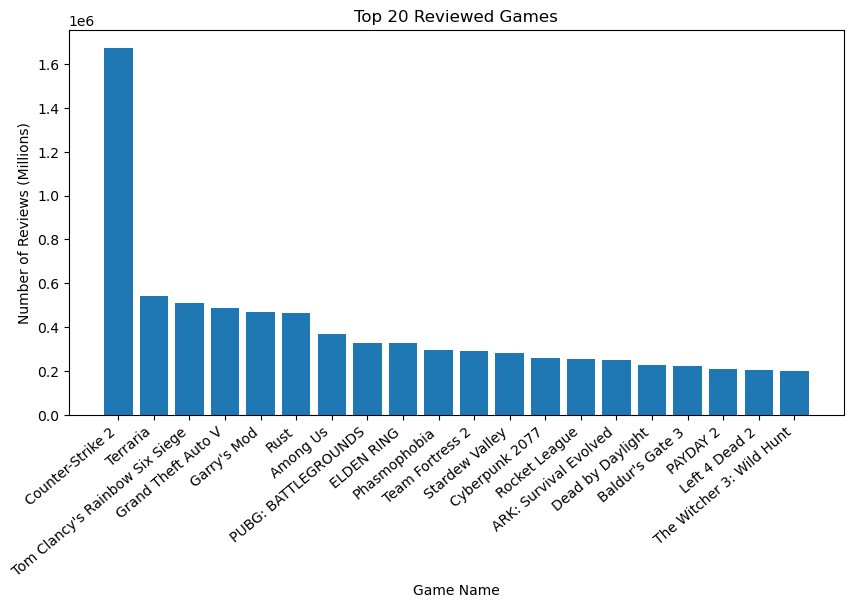

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(top_20_games['game'], top_20_games['count'])
plt.title('Top 20 Reviewed Games')
plt.xlabel('Game Name')
plt.ylabel('Number of Reviews (Millions)')
plt.xticks(rotation=40, ha='right')
plt.show()

From this, we can see that there are quite a lot of reviews for Counter-Strike 2! It seems like it is currently the most popular game, with a little over 3 times 
the review of the second game. So, it seems like our recommendation system will be working with Counter-Strike 2 the most. 

In [20]:
from pyspark.sql.functions import avg

game_list = top_20_games['game'].tolist()
playtime_top_20_games = reviews.filter(reviews['game'].isin(game_list))
playtime_top_20_games = playtime_top_20_games.select('game', 'author_playtime_forever').groupBy('game').agg(avg('author_playtime_forever').alias('average playtime')).toPandas()
playtime_top_20_games['average playtime'] = playtime_top_20_games['average playtime'] / 60 # Since the column is provided in minutes, get the hours instead
playtime_top_20_games = playtime_top_20_games.sort_values(by='average playtime', ascending=False)
display(playtime_top_20_games)

,game,average playtime
17,Counter-Strike 2,1144.519765
5,Rust,1022.012823
14,Team Fortress 2,958.340833
6,Rocket League,903.542835
9,ARK: Survival Evolved,785.044859
12,Garry's Mod,661.187541
10,Tom Clancy's Rainbow Six Siege,590.717222
11,Dead by Daylight,570.703271
16,PUBG: BATTLEGROUNDS,544.523183
0,Terraria,394.098752


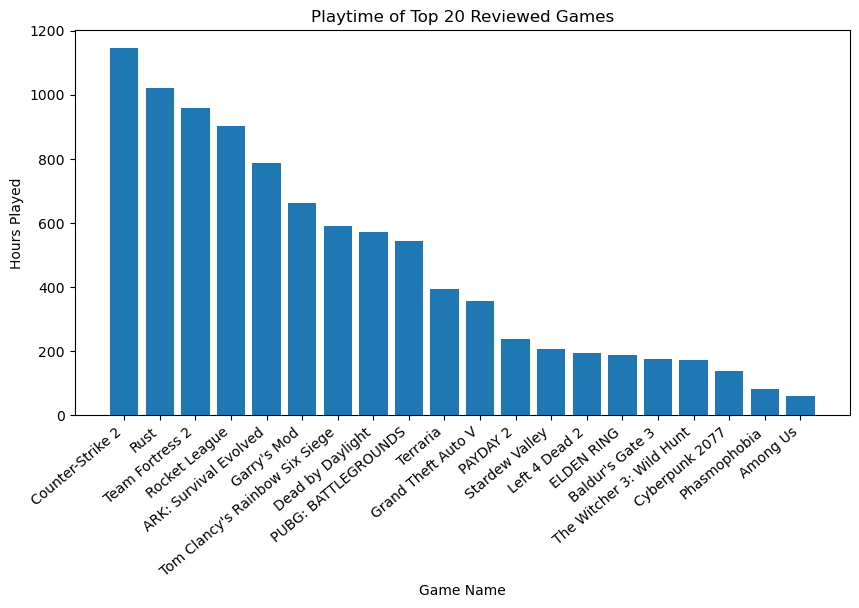

In [21]:
plt.figure(figsize=(10, 5))
plt.bar(playtime_top_20_games['game'], playtime_top_20_games['average playtime'])
plt.title('Playtime of Top 20 Reviewed Games')
plt.xlabel('Game Name')
plt.ylabel('Hours Played')
plt.xticks(rotation=40, ha='right')
plt.show()

Wow, it looks like Counter-Strike 2 and Rust is quite popular! Both have over 1000 hours. 

The following cell will explore the overall distribution of playtime across the entire dataset, presented with histogram. First 
we will take a small sample of data points from the main dataset as graphing libraries are not powerful enough to display data from the whole dataset.

In [22]:
sampled_reviews = reviews.sample(False, 0.001, seed=66).toPandas()
print(f'The sample has a size of {len(sampled_reviews)}.')

The sample has a size of 40288.


With this, we will take the log of the dataset as the playtime can vary widely, which will make the histogram very hard to visualize.

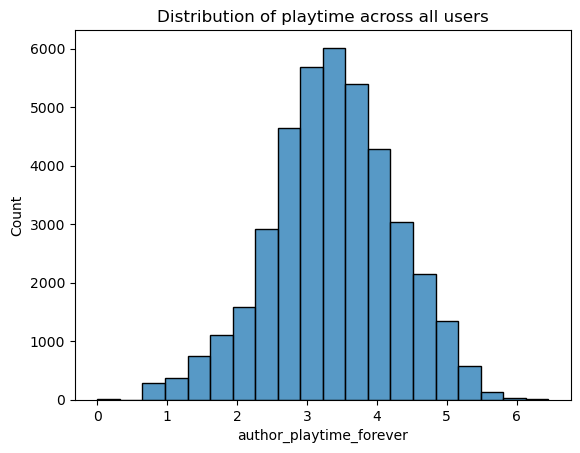

In [23]:
import seaborn as sns
import numpy as np

total_playtime_distribution = sampled_reviews.copy()
total_playtime_distribution['author_playtime_forever'] = np.log10(total_playtime_distribution['author_playtime_forever'])
sns.histplot(total_playtime_distribution, x='author_playtime_forever', label='Distribution of Playtime', bins=20)
plt.title('Distribution of playtime across all users')
plt.show()

The distribution seems to be mostly normal, and we can see that the distribution most commonly congregate at around 3 to 4. With a log of 10, 
we get that 10^3 = 316 and 10^4 = 10000. Since these are recorded with minutes, we have 1000/60 = 16.6 hours and 10000/60 = 166 hours. So it seems 
like more common occurences of playtime are between that interval, so there must be some big Counter-Strike 2 and Rust fans to drive that average playtime 
up so high! Also could be that the top games also has a much bigger playerbase than the smaller games.

The following cell, we will explore if there are any correlation between voted_up and playtime. 
We will utilize the same sample that we have created from earlier.

In [24]:
corr_vote_playtime = sampled_reviews.copy()
corr_vote_playtime['author_playtime_forever'] = np.log10(corr_vote_playtime['author_playtime_forever'])
corr_ = corr_vote_playtime['voted_up'].corr(corr_vote_playtime['author_playtime_forever'])
print(f'The correlation between recommendation and playtime is {corr_}.')

The correlation between recommendation and playtime is 0.18194392984202515.


It seems that the there is some slight positive correlation between recommending and playtime, although it is not as strong 
as we thought, it is understandable as we are trying to assume a linearity on a very complex relationship. Some reason 
for this is that it is difficult to assume linear relationship in the first place with a binary column (voted_up is 1 or 0). 
Another being that whether users keep playing certain games can vary widely based on the nature of the game itself - for example, 
a game like PUBG: Battlegrounds, players can match up with other players for infinite replayability but for a singleplayer game 
like Cyberpunk 2077, once you beat the game, there really isn't much reason to open it again. So, that's why we have other features 
such as sentiment analysis to perfect our pipeline.

For our last exploration and graph, we will take a look at the relationship between number of games owned and playtime.

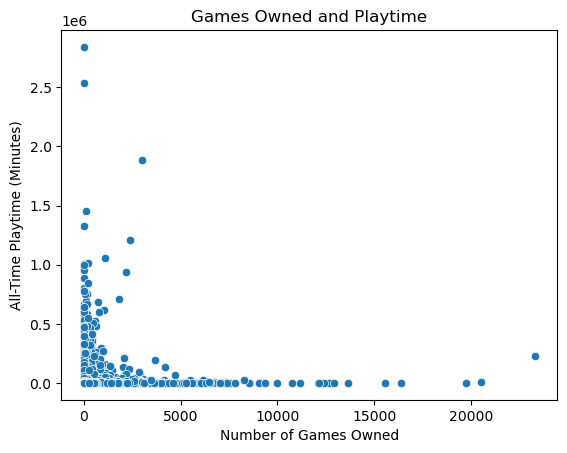

In [25]:
scatter_owned_playtime = sampled_reviews.copy()
scatter_owned_playtime = scatter_owned_playtime[['author_num_games_owned', 'author_playtime_forever']]

sns.scatterplot(scatter_owned_playtime, x='author_num_games_owned', y='author_playtime_forever')
plt.xlabel('Number of Games Owned')
plt.ylabel('All-Time Playtime (Minutes)')
plt.title('Games Owned and Playtime')
plt.show()

In [26]:
corr_owned_playtime = sampled_reviews.copy()
corr_owned_playtime['author_playtime_forever'] = np.log10(corr_owned_playtime['author_playtime_forever'])
corr_2 = corr_owned_playtime['author_num_games_owned'].corr(corr_owned_playtime['author_playtime_forever'])
print(f'The correlation between playtime and number of games owned is {corr_2}.')

The correlation between playtime and number of games owned is -0.13611357853490713.


This result is actually expected, because as an user own more games, the less time they would have to dedicate to each game, hence the lower playtime. This is captured <br>
in the scatterplot as well as in the negative correlation.

The next section we will begin preprocessing our data and building our first model. We will attempt to do this by utilizing 
the NLTK library and tokenize our words that way. 

# Part 3 - Building our First Model

In this section, we will build our first model - a logistic regression model that takes in our preprocessed tokens as features 
and performs a sentiment analysis to see whether the review is positive or not. To start, the following sections will begin preprocessing 
for our text reviews. We will utilize NLTK and its built-in functions like stopword removal and tokenization features. 

### Preprocessing Text using NLTK

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

Here we will define our preprocessing function, named process_text. We will use this function on our 'review' column to get it ready for training to our models. 
We will initatilze two functions, one more splitting the review text into sentences, which is more useful for sentiment analysis, and one to tokenize individual 
words to keep as backup and to see what words are the most commonly used.

In [28]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_word(text):
    words = word_tokenize(text)
    tokens = []

    useful_punct = ['!', '-', '?']

    for word in words:
        word_lower = word.lower()
        if word_lower not in stop_words:
            if word.replace('-', '').isalpha():
                word = '-'.join([lemmatizer.lemmatize(w, pos='v') for w in word.split('-')])
                tokens.append(word)
            elif word in useful_punct:
                tokens.append(word)

    return tokens

In [29]:
# Testing our function to see if it works!
process_word('This is a sample review! Make sure to upvote this.')

['sample', 'review', '!', 'Make', 'sure', 'upvote']

Before we start building our model, we want to address the skewed nature of the dataset where positive sentiment 
is over 86% while negative is 14%. In order for the model to not overfit, we will downsample positive sentiment 
to roughlt the same as negative. This will also help our following model processes as 40 million rows were simply 
too big to handle for the current spark enviornment. 

In [30]:
reviews = reviews.sampleBy('voted_up', {1: 0.14, 0: 1.0}, seed=66)

In [31]:
total_count_reduced = reviews.count()
voted_up_count_reduced = reviews.groupBy('voted_up').count().toPandas()
display(voted_up_count_reduced)
print(f'The new distribution is {round(voted_up_count_reduced["count"].iloc[0]/total_count_reduced*100, 2)}% and {round(voted_up_count_reduced["count"].iloc[1]/total_count_reduced*100, 2)}%.')

,voted_up,count
0,1,4946381
1,0,5095265


The new distribution is 49.26% and 50.74%.


The following cell will convert our above function into an user defined function and apply it to our dataset.

In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

word_udf = udf(process_word, ArrayType(StringType()))
reviews_processed = reviews.withColumn('processed_review', word_udf(reviews['review']))

Here we will take a small sample and see how it turned out by checking out 20 rows: <br>

In [33]:
print('Word Processed')
word_df = reviews_processed.limit(21).toPandas()[['review', 'processed_review']]
word_df = word_df.drop(1) # Dropping this row for vulgar language 
display(word_df)

Word Processed


,review,processed_review
0,cs2 update made the game barely playable on my...,"[update, make, game, barely, playable, laptop,..."
2,Counter-Strike 1.6 was a significant part of m...,"[Counter-Strike, significant, part, childhood,..."
3,I didn't get to play it during its peak. But e...,"[get, play, peak, even, years, good, game]"
4,classic. the best of the best since '03. with ...,"[classic, best, best, since, cs, go, removal, ..."
5,The phantom. Exterior like fish eggs. Interior...,"[phantom, Exterior, like, fish, egg, Interior,..."
6,Great,[Great]
7,sneak + a d is awesome,"[sneak, awesome]"
8,There are portals.,[portals]
9,countr stik,"[countr, stik]"
10,An absolute masterpiece of it's time. I want t...,"[absolute, masterpiece, time, want, modders, b..."


The following cell will explode all words and organize them as individual tokens instead of in a list, which then we will 
aggregate by count and find the top 20 most used words. However, since exploding these review lists in each row exponentially 
increase the size of the dataset. We will take a 1,000,000 sample of the dataset and find the result.

In [34]:
from pyspark.sql.functions import rand

reviews_processed_reduced = reviews_processed.orderBy(rand(seed=66)).limit(1000000)

In [35]:
from pyspark.sql.functions import explode

exploded_words = reviews_processed_reduced.select(explode(reviews_processed_reduced['processed_review']).alias('word'))
word_counts = exploded_words.groupBy('word').count()
top_20_words = word_counts.orderBy('count', ascending=False).limit(20)

top_20_words.show()

+------+-------+
|  word|  count|
+------+-------+
|  game|1194649|
|     !| 348395|
|  play| 329517|
|   get| 263727|
|  like| 235515|
|  time| 170259|
|  good| 164295|
|  make| 162311|
|   fun| 151156|
|     ?| 124578|
|really| 123117|
|     -| 119308|
|   one| 118984|
|  even| 116728|
|    go| 109339|
| would| 107414|
|  much|  88661|
|  feel|  88268|
|   buy|  86506|
|  want|  83964|
+------+-------+



It seems like that some top words are positive. Such as good, fun, and exclaimation mark appears a lot which means 
that users often feel strongly about their review. These top words also match up with our earlier count of number of recommendations 
because there are way more recommendations than not, so it would make sense positive words will have a higher appearence rate.

This concludes our data exploration section, we will now proceed to build our first sampel based off of our processed text.

### Building the Logistic Regression Sentiment Analysis Model

To begin, we will utilize Hashing and IDF to create a TF-IDF features extraction. We wil first create a pipeline to extract said 
features and then fit it to our data so we can extract the features.

In [36]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline

hash = HashingTF(inputCol='processed_review', outputCol='features', numFeatures=8000)
idf = IDF(inputCol='features', outputCol='idf_features')
pipeline = Pipeline(stages=[hash, idf])
model = pipeline.fit(reviews_processed)
fitted_model = model.transform(reviews_processed)

The following cell will create a logistic model and split our feature-vectorized dataset into training and test 
sets. We will then fit our logisitic classifier to this dataset and create a prediction output that we can use 
to gauge the performance. We will need a cross validation method to fine tune our model - we have tried to use 
k-fold validation but Spark did not have enough memory to finish this task. So we will simply reserve 20% of the 
data for validation.

In [37]:
from pyspark.ml.classification import LogisticRegression

X_train, X_val, X_test = fitted_model.randomSplit([0.6, 0.2, 0.2], seed=66)
logistic_clf = LogisticRegression(featuresCol='idf_features', labelCol='voted_up')
logistic_model = logistic_clf.fit(X_train)

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

eval_ = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='voted_up')

We will test our accuracy on our validation set and fine tune our model based on the result. 
The output of training set accuracy is purely for visual reference and will not be used as an 
anchor point to fine tune our model.

In [43]:
pred_train = logistic_model.transform(X_train)
acc_train = eval_.evaluate(pred_train)
print(f'The model has an accuracy of: {round(acc_train, 4)} on the training set.')

The model has an accuracy of: 0.818 on the training set.


In [39]:
pred_val = logistic_model.transform(X_val)
acc_val = eval_.evaluate(pred_val)
print(f'The model has an accuracy of: {round(acc_val, 4)} on the validation set.')

The model has an accuracy of: 0.8175 on the validation set.


We will now run our model on the test set to get the test set accuracy.

In [40]:
test_pred = logistic_model.transform(X_test)
acc_test = eval_.evaluate(test_pred)
print(f'The model has an accuracy of: {round(acc_test, 4)} on the test set.')

The model has an accuracy of: 0.8171 on the test set.


Very interesting to see that the accuracy of the test set and validation set is very similar, it would be a red flag 
if the test set has a higher accuracy but it is not in this case. This could indicate a couple things, such as the model 
having a fairly well generalization and not overfitting to the data.

In [42]:
analysis = test_pred.groupBy('voted_up', 'prediction').count()
analysis.show()

+--------+----------+------+
|voted_up|prediction| count|
+--------+----------+------+
|       1|       0.0|129326|
|       0|       0.0|781841|
|       1|       1.0|860481|
|       0|       1.0|237462|
+--------+----------+------+



From the output, we can see that the model is making more mistakes predicting a bad sentiment as positive, which 
is to be expected as there were not a lot of negative labels to learn from, so much so that we had to downsample 
our positive labels to prevent overfitting.

### Conclusion

Our first model can be viewed as successful as we were able to produce a model that had relatively good accuracy despite the fact 
that it had skewed proportions for its labels (to which we fixed with downsampling). We tried different variations of token processing 
by choosing to keep specific punctuations and optimized how the tokenizer was treating words like 'very-fun'; where before, the tokenizer 
would remove the whole word instead of just removing the the dash in the middle. We also tried to utilize N-Gram models to fine tune our 
model but since a 2-gram model and above drasticially increase our number of tokens and we could not load enough memory in the Spark 
enviornment for it to successfully run - so we had to keep our unigram model. However, we were still able to produce a model that has a 
relatiecly high accuracy score However, we were still able to produce a model that has a relatiecly high accuracy score through continuous 
experimentation with our validation set. Something that we could have done better was to set up our Spark enviornment better as we had to 
make a couple of compromises - such as reducing our number of features for our model from 100000 to 8000 and not being able to experiment with 
2-Gram models like mentioned earlier. We could have also create a more robust downsampling or upsampling method as we are risking losing good 
information from the 30 million rows of positive labels we discarded. 

Our next model will be a linear regression that predicts playtime (a float) based on feature inputs such as the review text/sentiment and past playtime. 
Eventually, we will combine this Linear Regression model with our Logistic Regression model where the sentiment prediction will be fed into our linear 
regression model which outputs a predicted playtime. Then we will wrap all of these into a pipeline at the end and create a recommendation system by 
choosing the game with the highest projected playtime by the user. 

The next section we will create our second model - a linear regression model that predicts playtime based on inputs such as the full 
review text, past playtime, as well as the predicted sentiment from the logistic regression model. 

# Part 4 - Building the Second Model and Recommendation Pipeline

To be continued.

# Closing Thoughts

This project was a difficult one - there were a lot of experimentation and restart from scratches. Learning how to 
navigate PySpark was also difficult as learning to manage memory and having to test with different core and its 
memor sizes was a new concept. Although this project was not able to complete the recommendation pipeline, it still 
laid the foundation for the system and navigating through the dataset and building these two models were challenging 
but rewarding. Looking forward to revisiting this project in the future and finish building out the recommendation system. 